## Resample data into Healpix

1. Create HEALPix grid 
2. Extract data if it is still in a zip file
3. Interpolate from initial points to Healpix grid. Uses linear interpolation
4. Save file

In [7]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import zipfile
import matplotlib.pyplot as plt

import xarray as xr
import numpy as np
import xesmf as xe

import os
from pathlib import Path
import healpy as hp

In [11]:
# use "nearest neighbors" for datapoints outside the convex hull

In [2]:
input_dir = '../data/equiangular/5.625deg/'
nearest = True

if nearest:
    output_dir = '../data/healpix/5.625deg_nearest/'
else:
    output_dir = '../data/healpix/5.625deg/'
nside = 16
n_pixels = 12*(nside**2)

In [3]:
# New HEALPix grid
n_pixels = 12*(nside**2)
hp_lon, hp_lat = hp.pix2ang(nside, np.arange(n_pixels), lonlat=True, nest=True)
lon_idx = xr.DataArray(hp_lon, dims=["lon"])
lat_idx = xr.DataArray(hp_lat, dims=["lat"])

In [8]:
if nearest and not os.path.isdir(output_dir):
    !mkdir '../data/healpix/5.625deg_nearest/'

In [9]:
all_files = os.listdir(input_dir)
all_files

['toa_incident_solar_radiation',
 'total_precipitation',
 'potential_vorticity',
 'temperature_850',
 'vorticity',
 'geopotential_500',
 '10m_v_component_of_wind',
 'constants',
 'u_component_of_wind',
 'total_cloud_cover',
 'specific_humidity',
 '2m_temperature',
 '10m_u_component_of_wind',
 'temperature',
 'v_component_of_wind',
 'all_5.625deg.zip',
 'relative_humidity',
 'geopotential']

In [10]:
#all_files = os.listdir(input_dir)
all_files = ['toa_incident_solar_radiation', 'temperature_850', 'geopotential_500', 'constants', 'geopotential']

#all_files = ['toa_incident_solar_radiation']
for f in all_files:
    print('Working on ', f)
    
    # Check if file has been unzip
    if not os.path.isfile(input_dir + f + '/' + f + '_1979_5.625deg.nc') and not os.path.isfile(input_dir + f + '/' + f + '_5.625deg.nc'):
        print('Data Extraction...')
        # extract data in the same folder 
        with zipfile.ZipFile(input_dir + f + '/' + f + '_5.625deg.zip',"r") as zip_ref:
            zip_ref.extractall(input_dir + f + '/')
            
    # Interpolate
    print('Interpolation...')
    ds = xr.open_mfdataset(input_dir + f + '/*.nc', combine='by_coords')
    
    #linear interpolation
    if nearest:
        interp_ds = ds.interp(lon=('node', lon_idx), lat=('node', lat_idx)).interpolate_na(dim='node', method='nearest') 
    else:
        interp_ds = ds.interp(lon=('node', lon_idx), lat=('node', lat_idx)).interpolate_na(dim='node') 
    interp_ds = interp_ds.assign_coords(node=np.arange(n_pixels))
    
    # Create out folder
    out_path =  output_dir + f + "/"
    Path(out_path).mkdir(parents=True, exist_ok=True)
    
    # Save
    out_filename = f + '_5.625deg.nc'
    interp_ds.to_netcdf(out_path + out_filename)

Working on  toa_incident_solar_radiation
Interpolation...
Working on  temperature_850
Data Extraction...
Interpolation...
Working on  geopotential_500
Data Extraction...
Interpolation...
Working on  constants
Interpolation...
Working on  geopotential
Interpolation...


#### Try to use xESMF to perform the regridding

https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview

Use similar procedure to the one described in [Weather Bench](https://github.com/pangeo-data/WeatherBench/blob/master/src/regrid.py) to perform regridding with xEMSF

Regridding function: [xESMF Regridding](https://xesmf.readthedocs.io/en/latest/user_api.html?highlight=regridder#regridder)

### TODO: 
Right now it generates a grid of 3072x3072 pixels by doing the cross-product of all latitude and longitude values we provide. Not what we want. Find a way to specify the values without using a regular grid. 

Update [15.07]: xESMF does not handle grids that are not quadrilinear... look for an alternative

Update [16.07]: using xESMF, generate complete grid and then just select points of interest. Gionata suggests to take a deeper look since it may give the values at a certain point while what we aim for is the value representative of the grid cell of study. Explore alternative of just padding the tensor and perform classic interpolation. 

In [4]:
ds_aux = xr.open_mfdataset(input_dir + 'toa_incident_solar_radiation' + '/*.nc', combine='by_coords')

In [12]:
ds_old = xr.open_mfdataset(output_dir + 'toa_incident_solar_radiation' + '/*.nc', combine='by_coords')

Create input and output grids

In [8]:
# input grid
grid_in = xr.Dataset(
        {'lat': (['lat'], ds_aux.lat),'lon': (['lon'], ds_aux.lon)}
    )

# output grid
grid_out = xr.Dataset(
        {'lat': ('lat', lat_idx),'lon': ('lon', lon_idx)}
    )

In [9]:
method = 'bilinear'
reuse_weights = True

regridder = xe.Regridder(
        grid_in, grid_out, method, reuse_weights=reuse_weights,
    )

Reuse existing file: bilinear_32x64_3072x3072.nc


In [10]:
ds_in = ds_aux

In [13]:
# regrid 
ds_list = []
chunk_size = 500
n_chunks = len(ds_in.time) // chunk_size + 1
for i in range(n_chunks):
    ds_small = ds_in.isel(time=slice(i*chunk_size, (i+1)*chunk_size))
    ds_list.append(regridder(ds_small).astype('float64'))
ds_out = xr.concat(ds_list, dim='time')

using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal

using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal

using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal

In [14]:
# select only nodes we are interested in
ds_list_out = []
for i in range(n_pixels):
    print('\r{}'.format(i), end="")
    ds_list_out.append(ds_out.isel({'lat':[i], 'lon':[i]}).drop_vars(['lon','lat']))

3071

In [15]:
# create array
ds_out_sampled = xr.concat(ds_list_out, dim='node')

In [16]:
# assign node as coordinates
ds_out_sampled = ds_out_sampled.assign_coords(node=np.arange(n_pixels))

In [17]:
# drop dimensions with single value
ds_out_sampled = ds_out_sampled.squeeze()

In [18]:
# add latitude and longitude information
ds_out_sampled = ds_out_sampled.assign_coords(lat=('node', lat_idx))
ds_out_sampled = ds_out_sampled.assign_coords(lon=('node', lon_idx))

In [19]:
# match previous order of dimensions
ds_out_sampled.transpose()

,Array,Chunk
Bytes,8.62 GB,4.00 kB
Shape,"(350633, 3072)","(500, 1)"
Count,13660455 Tasks,2276352 Chunks
Type,float64,numpy.ndarray


Original grid

Plot of values on the original grid. Dots in red represent the new grid.

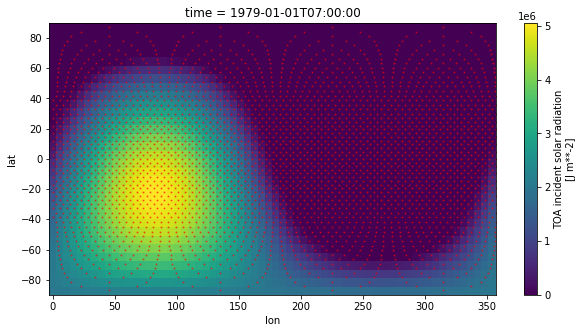

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
ds_aux.tisr.isel(time=0).plot(ax=ax)
ax.plot(lon_idx.values, lat_idx.values, 'o', alpha=0.5, c='red', markersize=1)
plt.show()

Interpolated with xESMF

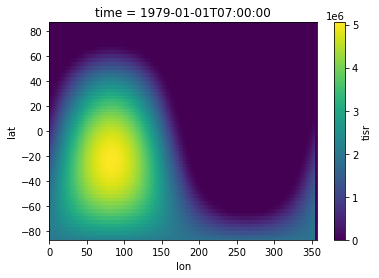

In [19]:
ax = ds_out.tisr.isel(time=0).sortby(['lon','lat']).plot()

Interpolated with xArray

In [23]:
ds_old

<xarray.Dataset>
Dimensions:  (node: 3072, time: 350633)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T07:00:00 ... 2018-12-31T23:00:00
    lat      (node) float64 dask.array<chunksize=(3072,), meta=np.ndarray>
    lon      (node) float64 dask.array<chunksize=(3072,), meta=np.ndarray>
  * node     (node) int64 0 1 2 3 4 5 6 7 ... 3065 3066 3067 3068 3069 3070 3071
Data variables:
    tisr     (time, node) float64 dask.array<chunksize=(350633, 3072), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-12-07 20:42:10 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

This does **NOT** work

```python
ds_list_out = []
for i in range(3072):
    print('\r{}'.format(i), end="")
    ds_list_out.append(ds_out.isel({'lat':[i], 'lon':[i]}))
ds_out_sampled = xr.concat(ds_list_out, dim='time')
```

Compare format of both methods

In [24]:
ds_out_sampled

,Array,Chunk
Bytes,8.62 GB,4.00 kB
Shape,"(3072, 350633)","(1, 500)"
Count,11384103 Tasks,2276352 Chunks
Type,float64,numpy.ndarray


In [25]:
ds_old

<xarray.Dataset>
Dimensions:  (node: 3072, time: 350633)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T07:00:00 ... 2018-12-31T23:00:00
    lat      (node) float64 dask.array<chunksize=(3072,), meta=np.ndarray>
    lon      (node) float64 dask.array<chunksize=(3072,), meta=np.ndarray>
  * node     (node) int64 0 1 2 3 4 5 6 7 ... 3065 3066 3067 3068 3069 3070 3071
Data variables:
    tisr     (time, node) float64 dask.array<chunksize=(350633, 3072), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-12-07 20:42:10 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

Dimension and types match. 

In [37]:
ds_plot = ds_out_sampled.isel(time=0)

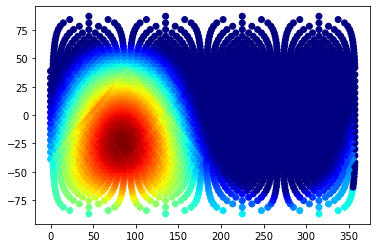

In [39]:
norm_values = (ds_plot.tisr.values - np.min(ds_plot.tisr.values)) / (np.max(ds_plot.tisr.values) - np.min(ds_plot.tisr.values))
plt.scatter(ds_plot.lon, ds_plot.lat, c=norm_values, cmap='jet')

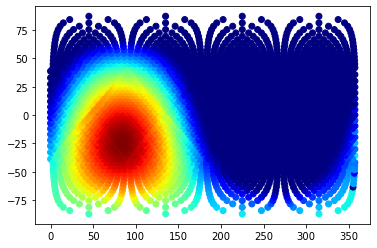

In [40]:
ds_plot_old = ds_old.isel(time=0)
norm_values_old = (ds_plot_old.tisr.values - np.min(ds_plot_old.tisr.values)) / (np.max(ds_plot_old.tisr.values) - np.min(ds_plot_old.tisr.values))
plt.scatter(ds_plot_old.lon, ds_plot_old.lat, c=norm_values_old, cmap='jet')

In [41]:
ds_in

,Array,Chunk
Bytes,2.87 GB,71.96 MB
Shape,"(350633, 32, 64)","(8784, 32, 64)"
Count,120 Tasks,40 Chunks
Type,float32,numpy.ndarray


From visual inspection, we can see the main differences are located at lon=360º 

#### Explore differences between both methods

Check if the interpolated values have differences

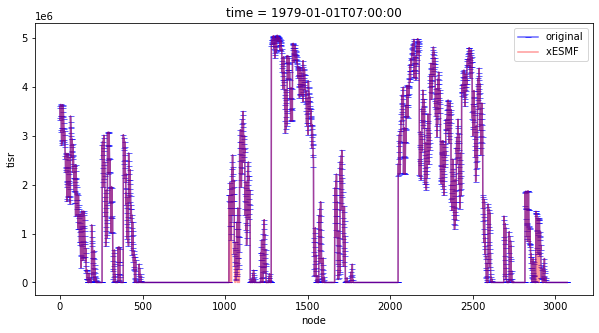

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
ds_old.tisr.isel(time=0).plot(ax=ax, alpha=0.6, c='b', marker='_')
ds_out_sampled.tisr.isel(time=0).plot(ax=ax, alpha=0.4, c='r')
plt.legend(['original', 'xESMF '])
plt.show()

In [45]:
diff = ds_old.tisr.isel(time=0) - ds_out_sampled.tisr.isel(time=0)

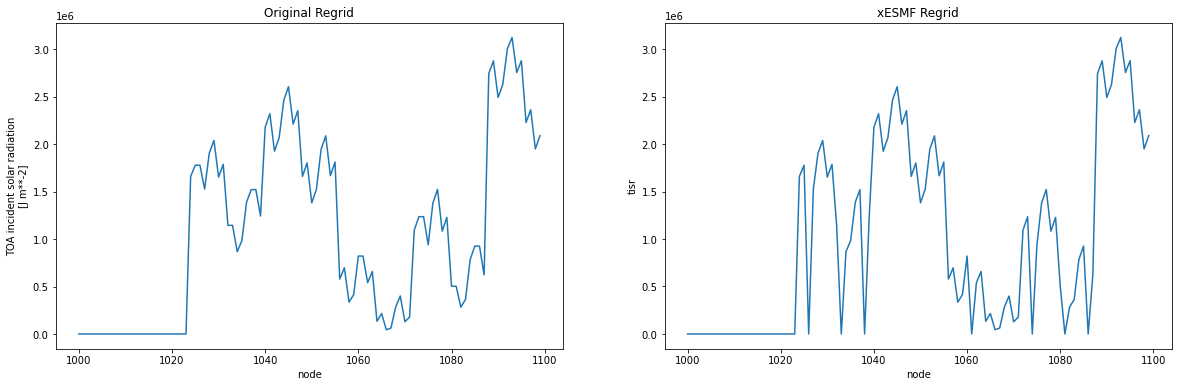

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ds_old.tisr.isel(time=0, node=np.arange(1000, 1100)).plot(ax=ax[0])
ds_out_sampled.tisr.isel(time=0, node=np.arange(1000, 1100)).plot(ax=ax[1])

ax[0].set_title('Original Regrid')
ax[1].set_title('xESMF Regrid')

plt.show()

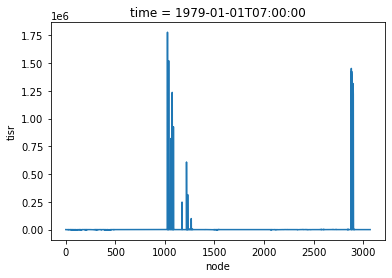

In [46]:
diff.plot()

Plot location of nodes where interpolation is not exactly the same

In [50]:
nodes = np.where(diff.values != 0)

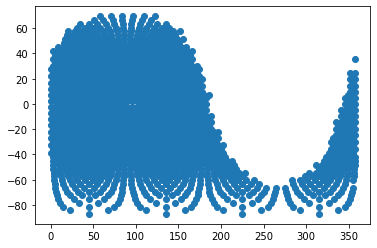

In [56]:
plt.scatter(diff.isel(node=nodes[0]).lon, diff.isel(node=nodes[0]).lat)

Plot location of nodes where interpolation difference is larger than 1e5

In [58]:
nodes_sig = np.where(diff.values > 0.1e6)

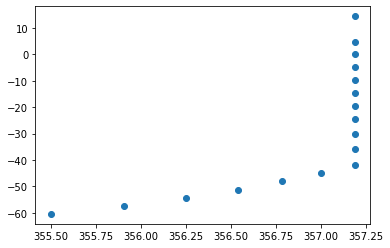

In [59]:
plt.scatter(diff.isel(node=nodes_sig[0]).lon, diff.isel(node=nodes_sig[0]).lat)

We have 17 points located at the border of the longitud value where the interpolation differ from more than 1e5. These points are set to their nearest neighbor value in the "old setting" while they are probably zero using the new interpolation setting. The new interpolation setting does not work as expected. 

**TODO:** Pad the array with the intial values to take into account the spherical shape and try linear interpolation in such a way.